In [50]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [51]:
# ==========================================
#              USER CONFIGURATION
# ==========================================

# 1. File Paths & Selection
FOLDER_PATH = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/data_sync/outputs"

# Filter: Only load files containing this string (e.g., "NR" or "WR")
# Set to "" (empty string) to load EVERYTHING.
FILE_FILTER = "NR" 

# List of specific filenames to use as the TEST set. 
# These will be excluded from training/validation automatically.
TEST_FILES = [
    "BIA24-5_NR_merged_with_gear.csv",
    "BIA24-22_NR_merged_with_gear.csv",
    "BIA24-5_WR_merged_with_gear.csv",
    "BIA24-22_WR_merged_with_gear.csv",
]

# 2. Input Features
INPUT_COLS = [
    'speed_kmph', 'power_w', 'frequency_ppm', 
    'thrust_left_ms', 'thrust_right_ms', 
    'impulse_left_ns', 'impulse_right_ns', 
    'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 
    'ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts'
]

# 3. Output Label
LABEL_COL = "Gear"

# 4. Data Processing
SEQ_LEN = 5       # Frames
STEP = 1           # Stride

# 5. Model Architecture
HIDDEN_DIM = 32
NUM_LAYERS = 3
DROPOUT = 0.2

# 6. Training Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.00005
EPOCHS = 120

In [52]:
# 1. Get list of files based on filter
all_csvs = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.csv')]

# Apply the text filter (NR or WR)
if FILE_FILTER:
    csv_files = [f for f in all_csvs if FILE_FILTER in f]
    print(f"Filter '{FILE_FILTER}' applied. Found {len(csv_files)} files.")
else:
    csv_files = all_csvs
    print(f"No filter applied. Found {len(csv_files)} files.")

# 2. Load Dataframes
dataframes = {}
for file in csv_files:
    full_path = os.path.join(FOLDER_PATH, file)
    df = pd.read_csv(full_path)
    dataframes[file] = df

# 3. Validation: Check if Test Files exist in the loaded list
# If a test file doesn't match the filter (e.g. asking for an NR file while filtering for WR), warn the user.
valid_test_files = []
for tf in TEST_FILES:
    if tf in dataframes:
        valid_test_files.append(tf)
    else:
        print(f"WARNING: Test file '{tf}' not found in loaded data (Check your FILTER setting).")

TEST_FILES = valid_test_files
print(f"Valid Test Files: {len(TEST_FILES)}")

# --- CLASS MERGING FUNCTION ---
def clean_gear_label(gear):
    s = str(gear).strip()
    if '2.0' in s:
        return '2.0'
    return s

# Apply cleaning
for k, df in dataframes.items():
    if LABEL_COL in df.columns:
        df[LABEL_COL] = df[LABEL_COL].apply(clean_gear_label)

print("Class merging complete.")

Filter 'NR' applied. Found 12 files.
Valid Test Files: 2
Class merging complete.


In [53]:
# 1. Identify keys available for training
# We take all loaded keys MINUS the test files
train_pool_keys = sorted([k for k in dataframes.keys() if k not in TEST_FILES])

# 2. Split files for Train/Val
train_keys, val_keys = train_test_split(train_pool_keys, test_size=0.2, random_state=42)

print(f"Train files: {len(train_keys)}")
print(f"Val files:   {len(val_keys)}")
print(f"Test files:  {len(TEST_FILES)} -> {TEST_FILES}")

# 3. Concatenate for Scaler/Encoder fitting
train_df = pd.concat([dataframes[k] for k in train_keys], ignore_index=True)
val_df = pd.concat([dataframes[k] for k in val_keys], ignore_index=True)

# Combine all test DFs
test_dfs_list = [dataframes[k] for k in TEST_FILES]
if test_dfs_list:
    test_df = pd.concat(test_dfs_list, ignore_index=True)
else:
    raise ValueError("No valid test files found! Check your configuration.")

# Drop NaNs
train_df = train_df.dropna(subset=INPUT_COLS + [LABEL_COL])
val_df = val_df.dropna(subset=INPUT_COLS + [LABEL_COL])
test_df = test_df.dropna(subset=INPUT_COLS + [LABEL_COL])

# 4. Fit Label Encoder
all_labels = pd.concat([train_df[LABEL_COL], val_df[LABEL_COL], test_df[LABEL_COL]]).unique()
encoder = LabelEncoder()
encoder.fit(all_labels)
print(f"Classes found: {encoder.classes_}")

# 5. Fit Scaler (TRAIN ONLY)
scaler = StandardScaler()
scaler.fit(train_df[INPUT_COLS])
print("Scaler fitted on training data.")

Train files: 8
Val files:   2
Test files:  2 -> ['BIA24-5_NR_merged_with_gear.csv', 'BIA24-22_NR_merged_with_gear.csv']
Classes found: ['0.0' '2.0' '3.0' '4.0']
Scaler fitted on training data.


In [54]:
def create_sequences(df, seq_len, step):
    X_vals = df[INPUT_COLS].values
    y_vals = encoder.transform(df[LABEL_COL].values)
    
    # Scale features
    X_vals = scaler.transform(X_vals)
    
    X_seqs = []
    y_seqs = []
    
    # Loop through data to create windows
    num_samples = len(df)
    for start_idx in range(0, num_samples - seq_len + 1, step):
        end_idx = start_idx + seq_len
        
        # Input sequence: Rows from start to end
        seq_x = X_vals[start_idx:end_idx]
        
        # Label: The label at the VERY END of the sequence
        # (This is standard for 'current state' classification)
        label_y = y_vals[end_idx - 1]
        
        X_seqs.append(seq_x)
        y_seqs.append(label_y)
        
    return np.array(X_seqs, dtype=np.float32), np.array(y_seqs, dtype=np.int64)

def prepare_dataset(keys, df_source):
    # If source is a list of keys (for dictionary), iterate and concat
    # If source is a single DataFrame (like test), just process it
    
    if isinstance(df_source, pd.DataFrame):
        return create_sequences(df_source, SEQ_LEN, STEP)
    
    # Otherwise, it's a list of keys for the 'dataframes' dict
    X_all, y_all = [], []
    for k in keys:
        df = dataframes[k].dropna(subset=INPUT_COLS + [LABEL_COL])
        X, y = create_sequences(df, SEQ_LEN, STEP)
        if len(X) > 0:
            X_all.append(X)
            y_all.append(y)
            
    return np.concatenate(X_all), np.concatenate(y_all)

print("Building sequences...")
X_train, y_train = prepare_dataset(train_keys, dataframes)
X_val, y_val = prepare_dataset(val_keys, dataframes)
X_test, y_test = prepare_dataset(None, test_df) # Pass DF directly

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

# Create DataLoaders
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=BATCH_SIZE, shuffle=False)

Building sequences...
Train shape: (9062, 5, 14)
Val shape:   (2169, 5, 14)
Test shape:  (2415, 5, 14)


/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

Starting training...
Epoch [1/120] Train Loss: 1.3440 | Val Loss: 1.2978 | Val Acc: 62.75%
Epoch [2/120] Train Loss: 1.3035 | Val Loss: 1.2156 | Val Acc: 62.75%
Epoch [3/120] Train Loss: 1.2211 | Val Loss: 1.0325 | Val Acc: 62.75%
Epoch [4/120] Train Loss: 1.0863 | Val Loss: 0.8779 | Val Acc: 67.17%
Epoch [5/120] Train Loss: 0.9568 | Val Loss: 0.7944 | Val Acc: 78.28%
Epoch [6/120] Train Loss: 0.8656 | Val Loss: 0.7489 | Val Acc: 73.35%
Epoch [7/120] Train Loss: 0.8086 | Val Loss: 0.7232 | Val Acc: 72.57%
Epoch [8/120] Train Loss: 0.7714 | Val Loss: 0.7106 | Val Acc: 72.52%
Epoch [9/120] Train Loss: 0.7438 | Val Loss: 0.7028 | Val Acc: 73.03%
Epoch [10/120] Train Loss: 0.7171 | Val Loss: 0.6944 | Val Acc: 74.09%
Epoch [11/120] Train Loss: 0.7000 | Val Loss: 0.6847 | Val Acc: 74.00%
Epoch [12/120] Train Loss: 0.6825 | Val Loss: 0.6727 | Val Acc: 74.23%
Epoch [13/120] Train Loss: 0.6638 | Val Loss: 0.6649 | Val Acc: 73.77%
Epoch [14/120] Train Loss: 0.6513 | Val Loss: 0.6586 | Val Acc: 7

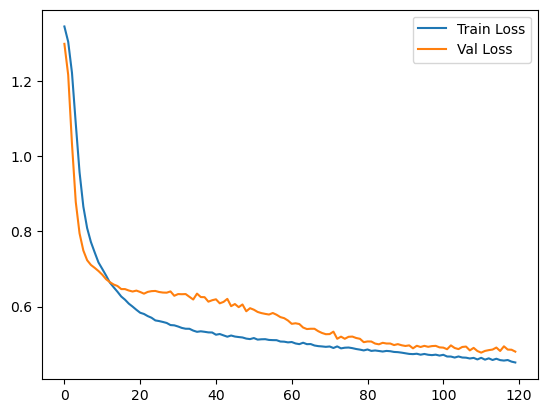

In [55]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        # lstm_out shape: (batch, seq_len, hidden_dim)
        lstm_out, _ = self.lstm(x)
        
        # Take only the last time step
        last_step = lstm_out[:, -1, :]
        
        out = self.fc(last_step)
        return out

model = SimpleLSTM(
    input_dim=len(INPUT_COLS),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=len(encoder.classes_),
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- TRAINING LOOP ---
train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()


--- Test Set Classification Report ---
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       391
         2.0       0.94      0.88      0.91       363
         3.0       0.91      0.93      0.92      1430
         4.0       0.56      0.47      0.51       231

    accuracy                           0.86      2415
   macro avg       0.80      0.78      0.79      2415
weighted avg       0.86      0.86      0.86      2415



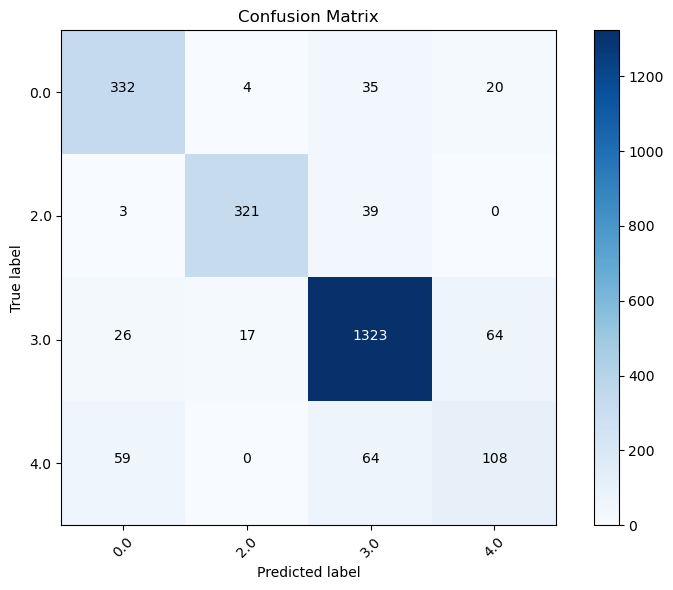

In [56]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Evaluation Metrics
print("\n--- Test Set Classification Report ---")
# Use zero_division=0 to handle classes that might not appear in the test set
print(classification_report(all_labels, all_preds, target_names=encoder.classes_, zero_division=0))

# Confusion Matrix with Matplotlib
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(encoder.classes_))
plt.xticks(tick_marks, encoder.classes_, rotation=45)
plt.yticks(tick_marks, encoder.classes_)

# Label the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()